**Projeto: Criando modelos com Python e Machine Learning para prever a evolução do COVID-19 no Brasil**

---

**DIO**

# Instalando e importando as bibliotecas necessárias

In [ ]:
!pip install pmdarima

In [ ]:
!pip install prophet

In [41]:
#Para tudo
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go 

#Para corrigir os rótulos das colunas
import re

#Para as análises preditivas
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#Para modelagem
from pmdarima.arima import auto_arima
from prophet import Prophet

# Carregando os dados para o projeto

In [42]:
#Importando os dados para o projeto contidos em uma url
url = 'https://github.com/neylsoncrepalde/projeto_eda_covid/blob/master/covid_19_data.csv?raw=true'

#  Montando nosso DataFrame

In [43]:
#Criando o nosso DataFrame
df = pd.read_csv(url, parse_dates=['ObservationDate', 'Last Update'])
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


In [44]:
#Conferindo os tipos de cada coluna
df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

Nomes de colunas não devem conter letras maiúsculas e/ou caracteres especiais.

In [45]:
#Implementando função para limpar os rótulos das colunas
def corrige_colunas(col_name):
  return re.sub(r"[/| ]", "", col_name).lower()

In [46]:
#Testando a função
corrige_colunas("Adg/  ou")

'adgou'

In [47]:
#Corrigindo todos os rótulos das colunas do nosso DataFrame
df.columns = [corrige_colunas(col) for col in df.columns]

In [48]:
df

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


# Selecionando os dados do Brasil

In [49]:
brasil = df.loc[(df.countryregion == 'Brazil') & 
                (df.confirmed > 0)]

In [50]:
brasil

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0


## Casos confirmados

In [51]:
#Gráfico da evolução de casos confirmados
px.line(brasil, 'observationdate', 'confirmed', title='<b>Casos Confirmados no Brasil</b>').update_layout(
    title={ 'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},         
            xaxis_title="<b>Data</b>",
            yaxis_title="<b>Casos Confirmados</b>") #Apartir de ".update_layout" é apenas para estilização do gráfico. Ou seja, não é necessário.

## Novos casos por dia

In [ ]:
#Técnica de programação funcional
brasil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],
    np.arange(brasil.shape[0])
))

In [53]:
brasil

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered,novoscasos
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,1.0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0,17126.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0,13220.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0,7569.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0,14288.0


In [54]:
#Gráfico de novos casos por dia no Brasil
px.line(brasil, x='observationdate', y='novoscasos', title='<b>Novos Casos Por Dia</b>').update_layout(
    title={ 'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},         
            xaxis_title="<b>Data</b>",
            yaxis_title="<b>Novos Casos</b>")

## Mortes

In [55]:
#Gráfico de mortes por COVID-19 no Brasil
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=brasil.observationdate, y=brasil.deaths, name='Mortes', mode='lines+markers', line={'color':'red'})    
)

#Layout
fig.update_layout(
    title={'text':'<b>Mortes por COVID-19 no Brasil</b>',
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},         
            xaxis_title="<b>Data</b>",
            yaxis_title="<b>Novos Casos</b>")
fig.show()

## Taxa de crescimento




*taxa_crescimento = ( (presente/passado)^(1/n) ) - 1*

In [56]:
#Criando uma função para calcular a taxa de cresimento da COVID, no Brasil, em determinado periodo de tempo
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
  #Se data_inicio for None, definir como a primeira data disponível
  if data_inicio == None:
    data_inicio = data.observationdate.loc[data[variable] > 0].min()
  else:
    data_inicio = pd.to_datetime(data_inicio)

  if data_fim == None:
    data_fim = data.observationdate.iloc[-1]
  else:
    data_fim = pd.to_datetime(data_fim)


  #definindo os valores do presente e passado
  passado = data.loc[data.observationdate == data_inicio, variable].values[0]
  presente = data.loc[data.observationdate == data_fim, variable].values[0]

  #Definir o número de pontos no tempo que iremos avaliar
  n = (data_fim - data_inicio).days

  #Calculando a taxa
  taxa = (presente/passado)**(1/n) - 1

  return taxa*100

In [57]:
#Taxa de crescimento médio da COVID no Brasil em todo o período
taxa_crescimento(brasil, 'confirmed')

16.27183353112116

In [58]:
#Criando uma função par calcular a taxa de crescimento diário da COVID no Brasil
def taxa_crescimento_diaria(data, variable, data_inicio=None):
  #Se data_inicio for None, definir como a primeira data disponível
  if data_inicio == None:
    data_inicio = data.observationdate.loc[data[variable] > 0].min()
  else:
    data_inicio = pd.to_datetime(data_inicio)

  data_fim = data.observationdate.max()

  #Definir o número de pontos no tempo que iremos avaliar
  n = (data_fim - data_inicio).days

  #Taxa calculada de um dia para o outro
  taxas = list(map(
      lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1], range(1, n+1)
  ))
  
  return np.array(taxas) * 100

In [59]:
#Calculando da taxa de crescimento diária e salvando ela em uma variável
tx_dia = taxa_crescimento_diaria(brasil, 'confirmed')

In [60]:
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

In [61]:
#Gráfico da taxa de crescimento de casos de COVID confirmados no Brasil
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()

px.line(x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:], y=tx_dia, title='<b>Taxa de Crescimento de Casos Confirmados no Brasil</b>').update_layout(
    title={ 'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},         
            xaxis_title="<b>Data</b>",
            yaxis_title="<b>Taxa de Crescimento  %</b>")

## Predições

In [62]:
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate
confirmados

observationdate
2020-02-26         1.0
2020-02-27         1.0
2020-02-28         1.0
2020-02-29         2.0
2020-03-01         2.0
                ...   
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Name: confirmed, Length: 84, dtype: float64

In [63]:
res = seasonal_decompose(confirmados)

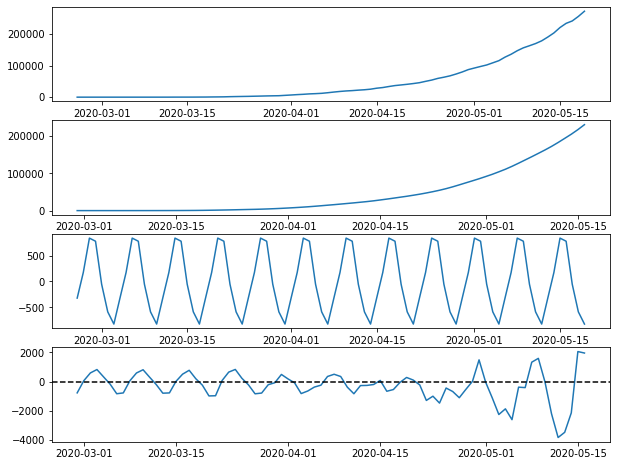

In [64]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))

ax1.plot(res.observed)                          # Gráfico dos observados
ax2.plot(res.trend)                             # Gráfico da tendência
ax3.plot(res.seasonal)                          # Gráfico da sazonalidade
ax4.plot(confirmados.index, res.resid)          # Gráfico do ruído
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

## Modelagem

### ARIMA (Média Movel Integrada Autoregressiva)

In [65]:
 modelo = auto_arima(confirmados)

In [66]:
#Gráfico da previsão de casos confirmados de COVID no Brasil, em determinado período de tempo
fig1 = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='<b>Observados</b>'
))
fig1.add_trace(go.Scatter(
    x=confirmados.index, y=modelo.predict_in_sample(), name='<b>Preditos</b>'
))
fig1.add_trace(go.Scatter(
    x=pd.date_range('2020-05-20', '2020-06-20'), y=modelo.predict(31), name='<b>Forecast</b>'
))
fig1.update_layout(title={ 'text':'<b>Previsão de Casos Confirmados no Brasil para os Proximos 30 dias</b>',
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig1.show()

### Modelagem de Crescimento

In [ ]:
#Pré-Processamento

train = confirmados.reset_index()[:-5]
test = confirmados.reset_index()[-5:]

#Renomeando colunas
train.rename(columns={'observationdate':'ds', 'confirmed':'y'}, inplace=True)
test.rename(columns={'observationdate':'ds', 'confirmed':'y'}, inplace=True)

#Definir o modelo de crescimento
profeta = Prophet(growth='logistic', changepoints=['2020-03-21', '2020-03-30', '2020-04-25', '2020-05-03', '2020-05-10'])

#pop = 211463256 #População do Brasil, segundo projeção do IBGE(2020)
pop = 1000000 #considere "pop" como a qauntidade de pessoas infectadas, alterar esse dado lhe dará varios cenários
train['cap'] = pop

#Treina o modelo
profeta.fit(train)

#Construindo previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast = profeta.predict(future_dates)

In [68]:
#Gráfico de predição de casos de COVID confirmados no Brasil
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='<b>Predição</b>'))
# fig2.add_trace(go.Scatter(x=test.index, y=test, name='<b>Observados - Teste</b>'))
fig2.add_trace(go.Scatter(x=train.ds, y=train.y, name='<b>Observados - Treino</b>'))
fig2.update_layout(title={ 'text':'<b>Predições de Casos Confirmados no Brasil</b>',
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig2.show()